In [303]:
import pandas as pd
import numpy as np
import json
import os
import requests as req
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline

os.chdir(r'C:\Users\user\Desktop\test')

<h3>Общие участники сообществ VK</h3>

**Суть задачи**: понять сходство между аудиторией нескольких (2 и больше) групп VK. 
<br>
<br>
Напишем функцию, которая собирает участников одной группы.

In [306]:
res = {}

def get_members(group):
    
    token = 'ваш токен для работы с VK API'
    version = 5.103
    offset = 0
    count = 1000

    ids = []
    response = req.get('https://api.vk.com/method/groups.getMembers',
                          params = {
                              'access_token': token,
                              'v': version,
                              'group_id': group,
                              'count': 0
                          })
    num = response.json()['response']['count']

    mod = 1000
    while offset < num:
        if num - offset < 1000:
            mod = num - offset
        response = req.get('https://api.vk.com/method/groups.getMembers',
                              params = {
                                  'access_token': token,
                                  'v': version,
                                  'group_id': group,
                                  'count': mod,
                                  'offset': offset
                          })
        data = response.json()['response']['items']
        offset += 1000
        ids.extend(data)
    res[group] = {'members': num, 'ids': ids}

**Пример.** <br>
<br>
Рассмотрим близость аудитории российских рэп-исполнителей.

**Ввод данных**: передадим одной строкой группы, которые необходимо проверить. <br>
**Сбор данных**: спарсим информацию об участниках для каждой из них. Вся информация (ссылка на группу, число участников в ней, их id) теперь хранится в словаре **res**.

In [307]:
print('Введите через пробел id (число или текстовая ссылка) групп для сравнения:')
groups = input().split()

Введите через пробел id (число или текстовая ссылка) групп для сравнения:
markulofficial killmeobladaet ogbuda platinarnbklub lilkrystalll atl_acidhouze deaddynasty lsp fleshaudiopunk benzogang_tape hauntedfamily pyrokines boulevardepo offmi face


In [310]:
progress = 0
print('Обработано групп: 0/{}'.format(len(groups)))
for group in groups:
    get_members(group)
    progress += 1
    print('Обработано групп: {}/{}'.format(progress, len(groups)))

Обработано групп: 0/15
Обработано групп: 1/15
Обработано групп: 2/15
Обработано групп: 3/15
Обработано групп: 4/15
Обработано групп: 5/15
Обработано групп: 6/15
Обработано групп: 7/15
Обработано групп: 8/15
Обработано групп: 9/15
Обработано групп: 10/15
Обработано групп: 11/15
Обработано групп: 12/15
Обработано групп: 13/15
Обработано групп: 14/15
Обработано групп: 15/15


**Преобразование в удобный вид**: запишем данные в датафрейм **people**. Это позволит удобно проводить векторные операции.

In [311]:
summary = pd.DataFrame(index = res.keys(), columns = res.keys()) # датасет для результатов подсчёта общих участников

id_set = {} # подготовка удобного словаря
for group in groups:
    id_set[group] = res[group]['ids']

people = pd.DataFrame.from_dict(id_set, orient='index').T # датасет с id участников
people = people.fillna(0)
people.head()

,markulofficial,killmeobladaet,ogbuda,platinarnbklub,lilkrystalll,atl_acidhouze,deaddynasty,lsp,fleshaudiopunk,benzogang_tape,hauntedfamily,pyrokines,boulevardepo,offmi,face
0,619.0,1359.0,3330.0,67890.0,1359.0,177.0,177.0,348.0,1359.0,636.0,1131.0,779.0,1359.0,67890.0,48.0
1,1359.0,2019.0,20347.0,108783.0,11460.0,636.0,619.0,985.0,49764.0,1359.0,1359.0,1359.0,3848.0,75541.0,619.0
2,3203.0,3140.0,26784.0,200990.0,67890.0,1359.0,1359.0,1359.0,50594.0,2395.0,1863.0,2027.0,4270.0,94174.0,1359.0
3,3450.0,3450.0,31555.0,243184.0,129910.0,1930.0,2395.0,1393.0,52036.0,5597.0,2395.0,3330.0,5170.0,95174.0,1544.0
4,4270.0,3809.0,44463.0,273737.0,181234.0,2395.0,2692.0,2395.0,54956.0,7525.0,2969.0,3450.0,7492.0,188154.0,1956.0


**Вычисление результатов**: для каждой пары групп найдём количество общих участников.Результат в датафрейме **summary**.

In [312]:
for i in people.columns: # подсчёт общих участников для каждой пары групп
    for j in people.columns:
        if i == j:
            summary.loc[i,j] = 0
        else:
            summary.loc[i, j] = len(people[people[i].isin(people[people[j] != 0][j].tolist())])

In [313]:
summary

,markulofficial,killmeobladaet,ogbuda,platinarnbklub,lilkrystalll,atl_acidhouze,deaddynasty,lsp,fleshaudiopunk,benzogang_tape,hauntedfamily,pyrokines,boulevardepo,offmi,face
markulofficial,0,94360,20412,20814,23988,55773,89492,97980,40569,69057,44650,36923,45284,14478,71461
killmeobladaet,94360,0,44530,45741,52048,54567,138546,104358,67991,116101,78606,38044,84300,31033,114958
ogbuda,20412,44530,0,53623,57799,12286,47619,28375,29841,61784,37922,10357,41498,24228,37769
platinarnbklub,20814,45741,53623,0,69679,11939,52268,30303,34871,64050,41211,11755,43644,26006,43692
lilkrystalll,23988,52048,57799,69679,0,12377,63963,35799,42532,82248,51875,13075,50063,29052,53954
atl_acidhouze,55773,54567,12286,11939,12377,0,74032,91632,19907,47575,33447,35765,42087,10913,53803
deaddynasty,89492,138546,47619,52268,63963,74032,0,204125,105729,182124,124710,55688,153504,38397,240880
lsp,97980,104358,28375,30303,35799,91633,204125,0,69709,113921,74078,64734,88127,23230,182158
fleshaudiopunk,40569,67991,29841,34871,42532,19907,105729,69709,0,87481,61685,21428,54115,24359,108209
benzogang_tape,69057,116101,61784,64050,82248,47575,182124,113921,87481,0,137028,36632,134211,42829,169685


**Визуализация**

Первый heatmap окрашен тривиально — в зависимости от количество общих участников. Однако это не совсем репрезентативно, так как не учитывается размер групп: конечно, у больших групп будет априори больше пересечений. Но это не значит, что их аудитории теснее связаны, чем аудитории маленьких групп.

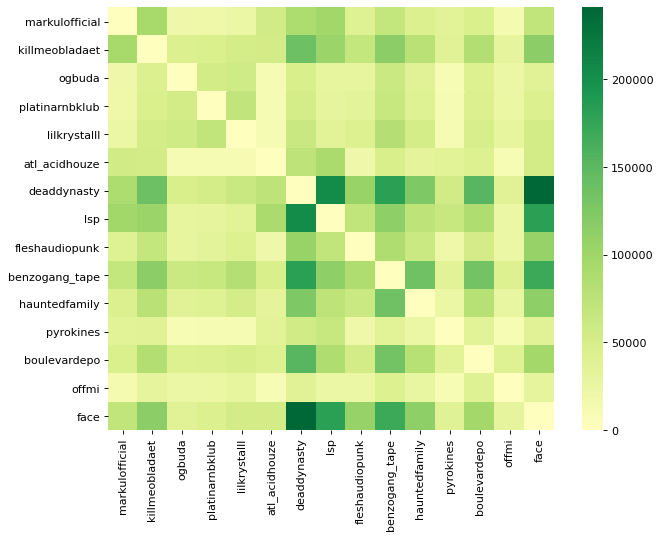

In [319]:
plt.figure(figsize=(9,7), dpi = 80)
sns.heatmap(summary, xticklabels = summary.columns, yticklabels = summary.columns, cmap='RdYlGn', center=0)
plt.show()

**Метрика для измерения «близости»**

Было принято измерять схожесть групп следующим образом: <br>
Пусть в двух группах $x_1$ и $x_2$ участников соответственно, среди которых $y$ общих. Тогда коэффициент близости:

$coef(x_1, x_2) = 100*(\frac{y}{x_1} + \frac{y}{x_2}) / 2$

Мы усредняем проценты общих участников для каждой группы. Такое решение позволяет не привязываться к численности групп. Плюс достаточно репрезентативно отражает реальный размер доли общих пользователей относительно каждый группы. <br>
Коэффициент выражен в процентах. Результаты в датафрейме **summary_total**.

In [317]:
summary_total = pd.DataFrame(index = res.keys(), columns = res.keys())
for i in summary_total.index:
    for j in summary_total.columns:
        summary_total.loc[i,j] = (100*((summary.loc[i,j]/res[i]['members']) + \
                                       (summary.loc[i,j]/res[j]['members']))/2).round(2)

for column in summary_total.columns:
    summary_total[column] = pd.to_numeric(summary_total[column], errors = 'coerce')
summary_total

,markulofficial,killmeobladaet,ogbuda,platinarnbklub,lilkrystalll,atl_acidhouze,deaddynasty,lsp,fleshaudiopunk,benzogang_tape,hauntedfamily,pyrokines,boulevardepo,offmi,face
markulofficial,0.00,26.03,11.86,11.47,10.88,14.57,17.94,19.19,14.19,15.23,11.69,11.48,12.71,11.24,13.92
killmeobladaet,26.03,0.00,25.59,24.92,23.27,13.90,26.87,19.76,23.34,24.85,20.08,11.59,23.12,23.89,21.65
ogbuda,11.86,25.59,0.00,45.58,43.48,6.88,23.77,14.04,19.36,32.09,21.26,6.32,24.05,26.05,18.65
platinarnbklub,11.47,24.92,45.58,0.00,50.33,6.33,24.53,14.08,21.57,31.34,21.87,6.82,23.99,27.18,20.26
lilkrystalll,10.88,23.27,43.48,50.33,0.00,5.35,23.76,13.14,22.15,32.21,22.46,6.30,22.62,27.52,19.74
atl_acidhouze,14.57,13.90,6.88,6.33,5.35,0.00,13.28,16.02,6.54,9.49,8.05,10.37,10.93,8.24,9.35
deaddynasty,17.94,26.87,23.77,24.53,23.76,13.28,0.00,23.25,28.31,25.24,22.44,12.76,30.51,26.66,27.19
lsp,19.19,19.76,14.04,14.08,13.14,16.02,23.25,0.00,18.35,15.27,12.99,14.53,17.12,16.02,19.74
fleshaudiopunk,14.19,23.34,19.36,21.57,22.15,6.54,28.31,18.35,0.00,25.19,20.31,8.11,18.84,20.55,28.38
benzogang_tape,15.23,24.85,32.09,31.34,32.21,9.49,25.24,15.27,25.19,0.00,27.41,9.13,29.38,30.60,22.57


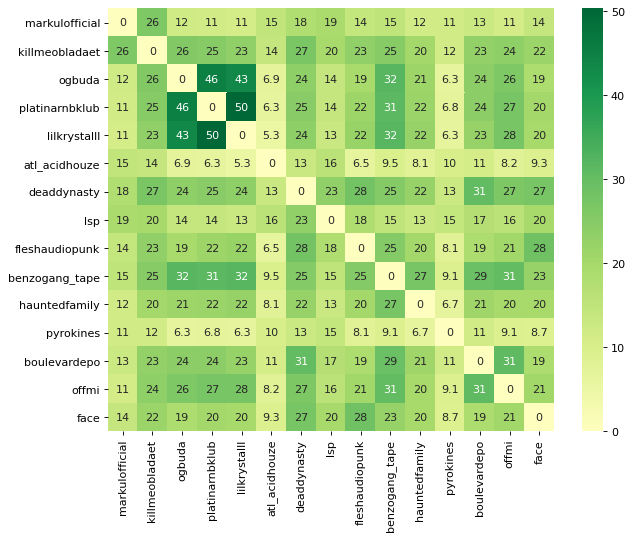

In [318]:
plt.figure(figsize=(9,7), dpi = 80)
sns.heatmap(summary_total, xticklabels = summary_total.columns, yticklabels = summary_total.columns, cmap='RdYlGn', center=0, annot = True)
plt.show()

**Дополнение.** <br>
<br>
Конечно, функционал можно успешно расширять. Например, ввести функции выгрузки общих пользователей для нескольких групп, в примере — 2 группы. Или найти самую близкую по аудитории группу.

In [340]:
def get_common_of_two():
    print('Введите две группы через пробел:')
    group1, group2 = input().split()
    common_users = list(set(res[group1]['ids']) & set(res[group2]['ids']))
    file_name = group1 + '_and_' + group2 + '.txt'
    with open(file_name, 'w') as f:
        for i in common_users:
            f.write(str(i) +'\n')
    print('Общих участников у групп: {}'.format(summary.loc[group1, group2]))
    print('ID общих участников сохранены в файл {}'.format(file_name))
    
def most_similar():
    print('Введите ссылку на группу:')
    group = input()
    group_link = 'http://vk.com/' + group
    similar = summary_total[group].idxmax()
    similar_link = 'http://vk.com/' + similar
    common_users = summary.loc[group, similar]
    print('Самое сильное пересечение у группы {} с группой {}. Общее число участников {}.'.format(group_link, similar_link, common_users))

In [343]:
most_similar()

Введите ссылку на группу:
lilkrystalll
Самое сильное пересечение у группы http://vk.com/lilkrystalll с группой http://vk.com/platinarnbklub. Общее число участников 69679.


In [341]:
get_common_of_two()

Введите две группы через пробел:
killmeobladaet boulevardepo
Общих участников у групп: 84300
ID общих участников сохранены в файл killmeobladaet_and_boulevardepo.txt
